<a href="https://colab.research.google.com/github/GitHub-Bong/Toxic-Comment-Challenge/blob/master/0402_change_model_from_Revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount , Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os, re, string, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GRU, LSTM, Embedding, Dropout, Activation, concatenate
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

------------

# Load Data

In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/train.csv/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/SOGANG Parrot/test.csv/test.csv')

-------

# Preprocessing

In [ ]:
# download the stopwords from NLTK
import nltk                         
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values # y.shape (159571, 6)
list_sentences_train = train["comment_text"] # (159571,)
list_sentences_test = test["comment_text"] # (153164,)

---------

# Tokenization

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_train[:1] = [[688,75,1,126,130, ,,, ]]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
# list_tokenized_test[:1] = [[2665,655,8849,656, ,,, ]]

# tokenizer.word_counts = OrderedDict([('explanation', 1771),('why', 17818),('the', 496540),('edits', 9957), ,,, ])
# tokenizer.word_index = {'the': 1,'to': 2,'of': 3,'and': 4, ,,, }

In [ ]:
len(tokenizer.word_index)

268591

------

# Padding

In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # (159571, 200)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # (153164, 200)

--------

# Pretrained-Embedding-matrix

In [ ]:
embedding_matrix = np.load('/content/drive/Shareddrives/SOGANG Parrot/Pretrained-Embedding-Vector/0401pretrained-embed-Glove.npy')
embedding_matrix.shape

(268591, 25)

-----

# Model

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=200
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
              weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(GRU(60, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
x = Dropout(0.1)(conc)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 25)      6714775     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 120)     31320       embedding_3[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 120)          0           bidirectional_2[0][0]            
______________________________________________________________________________________________

-----

# Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint
checkpoint = ModelCheckpoint(filepath='/content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-preprocessing-pretrained-embed-Glove.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

batch_size = 128
epochs = 5
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_split=0.1)

Epoch 1/5
1122/1122 [==============================] - 135s 92ms/step - loss: 0.1564 - accuracy: 0.8184 - val_loss: 0.1020 - val_accuracy: 0.9885

Epoch 00001: val_loss improved from inf to 0.10202, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-preprocessing-pretrained-embed-Glove.hdf5
Epoch 2/5
1122/1122 [==============================] - 101s 90ms/step - loss: 0.0984 - accuracy: 0.9823 - val_loss: 0.0891 - val_accuracy: 0.9935

Epoch 00002: val_loss improved from 0.10202 to 0.08913, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-preprocessing-pretrained-embed-Glove.hdf5
Epoch 3/5
1122/1122 [==============================] - 101s 90ms/step - loss: 0.0856 - accuracy: 0.9889 - val_loss: 0.0825 - val_accuracy: 0.9939

Epoch 00003: val_loss improved from 0.08913 to 0.08254, saving model to /content/drive/Shareddrives/SOGANG Parrot/Trained-Model/0402-preprocessing-pretrained-embed-Glove.hdf5
Epoch 4/5
1122/1122 [=================

# Prediction

In [ ]:
sample_submission = pd.read_csv("/content/drive/Shareddrives/SOGANG Parrot/sample_submission.csv/sample_submission.csv")

sample_submission[list_classes] = model.predict(X_te)

sample_submission.to_csv("/content/drive/Shareddrives/SOGANG Parrot/All-submission/20210402-ver3-modelchange-pretrained-embed-Glove.csv", index=False)

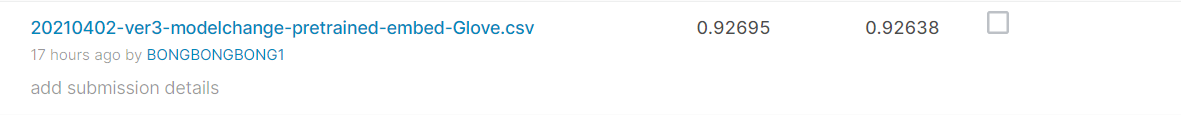